# Prerequisites

In [4]:
import numpy as np
import matplotlib.pyplot as pl
import numpy as np
import scanpy.api as sc
import pandas as pd
from scanpy.tools import rna_velocity
from anndata import AnnData
import seaborn as sns
from scipy.sparse import csr_matrix
import networkx as nx
import xlsxwriter
from matplotlib import rcParams
import seaborn as sns
import scipy as sci
import gseapy as gp
sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.3.2 anndata==0.6.10 numpy==1.15.4 scipy==1.2.1 pandas==0.23.4 scikit-learn==0.20.0 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


# Load raw data

In [ ]:
# Read cellranger files for all four samples
filename = './E12_5_counts/mm10/matrix.mtx'
filename_genes = './E12_5_counts/mm10/genes.tsv'
filename_barcodes = './E12_5_counts/mm10/barcodes.tsv'

e125 = sc.read(filename).transpose()
e125.var_names = np.genfromtxt(filename_genes, dtype=str)[:, 1]
e125.obs_names = np.genfromtxt(filename_barcodes, dtype=str)

filename = './E13_5_counts/mm10/matrix.mtx'
filename_genes = './E13_5_counts/mm10/genes.tsv'
filename_barcodes = './E13_5_counts/mm10/barcodes.tsv'

e135 = sc.read(filename).transpose()
e135.var_names = np.genfromtxt(filename_genes, dtype=str)[:, 1]
e135.obs_names = np.genfromtxt(filename_barcodes, dtype=str)

filename = './E14_5_counts/mm10/matrix.mtx'
filename_genes = './E14_5_counts/mm10/genes.tsv'
filename_barcodes = './E14_5_counts/mm10/barcodes.tsv'

e145 = sc.read(filename).transpose()
e145.var_names = np.genfromtxt(filename_genes, dtype=str)[:, 1]
e145.obs_names = np.genfromtxt(filename_barcodes, dtype=str)

filename = './E15_5_counts/mm10/matrix.mtx'
filename_genes = './E15_5_counts/mm10/genes.tsv'
filename_barcodes = './E15_5_counts/mm10/barcodes.tsv'

e155 = sc.read(filename).transpose()
e155.var_names = np.genfromtxt(filename_genes, dtype=str)[:, 1]
e155.obs_names = np.genfromtxt(filename_barcodes, dtype=str)




# Add dev. timepoint label for each sample
e125.obs['day'] = '12.5'
e135.obs['day'] = '13.5'
e145.obs['day'] = '14.5'
e155.obs['day'] = '15.5'
# Create Concatenated anndata object for all timepoints
alldays = e125.concatenate(e135, e145, e155)
# Deleting individual day arrays
del e125
del e135
del e145
del e155

# Preprocessing

## QC

Quality control - calculate QC covariates for all anndata objects

In [ ]:
print(alldays.obs['day'].value_counts()) # number of cells per sample (day)

In [ ]:
# #counts per cell
alldays.obs['n_counts'] = alldays.X.sum(1)
# #logcounts per cell
alldays.obs['log_counts'] = np.log(alldays.obs['n_counts'])
# #genes per cell
alldays.obs['n_genes'] = (alldays.X > 0).sum(1)
# mitochondrial gene fraction
mt_gene_mask = [gene.startswith('mt-') for gene in alldays.var_names]
mt_gene_index = np.where(mt_gene_mask)[0]
alldays.obs['mt_frac'] = alldays.X[:,mt_gene_index].sum(1) / alldays.X.sum(1)

Quality control - plot QC metrics

In [ ]:
#Sample quality plots
sc.pl.violin(alldays, ['n_counts', 'mt_frac'], groupby='day', size=1, log=False, cut=0)
#sc.pl.violin(alldays, 'mt_frac', groupby='day')

Filter cells according to identified QC thresholds

In [ ]:
print('Total number of cells: {:d}'.format(alldays.n_obs))
alldays = alldays[alldays.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(alldays.n_obs))

sc.pp.filter_cells(alldays, min_genes = 1200)
print('Number of cells after gene filter: {:d}'.format(alldays.n_obs))
#Filter genes:
print('Total number of genes: {:d}'.format(alldays.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(alldays, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(alldays.n_vars))

## Normalization

In [ ]:
#Keep a copy of the raw, filtered data in a separate anndata object
alldays_counts = alldays.copy()
#Log-transform data and perform quantile normalisation
sc.pp.log1p(alldays)
alldays.X = sci.sparse.csr_matrix(scanpy.preprocessing.simple.normalize_per_cell_weinreb16_deprecated(alldays.X.toarray(), max_fraction=0.05, mult_with_mean=True))
alldays.raw = alldays

## Filter highly variable genes

In [ ]:
# Keep a list of highly variable genes
disp_filter = sc.pp.filter_genes_dispersion(alldays.X, flavor='cell_ranger', n_top_genes=4000, log=False, )
print('Number of highly variable genes: {:d}'.format(alldays[:, disp_filter['gene_subset']].n_vars))
alldays.var['highly_variable_genes'] = disp_filter['gene_subset']
alldays.var['expression_mean'] = disp_filter['means']
alldays.var['dispersion'] = disp_filter['dispersions']
sc.pl.filter_genes_dispersion(disp_filter)

Create a data set with only the highly variable genes

In [ ]:
alldays_hvg = alldays.copy()
alldays_hvg = alldays_hvg[:, disp_filter['gene_subset']]

# Embedding

In [6]:
sc.pp.pca(alldays_hvg)
sc.pp.neighbors(alldays_hvg)
sc.tl.diffmap(alldays_hvg)
sc.tl.umap(alldays_hvg)

In [2]:
#Transfer UMAP and other coordinates to full data objects
alldays.obsm['X_umap'] = alldays_hvg.obsm['X_umap']
alldays.obsm['X_tsne'] = alldays_hvg.obsm['X_tsne']
alldays.obsm['X_diffmap'] = alldays_hvg.obsm['X_diffmap']
alldays.uns['diffmap_evals'] = alldays_hvg.uns['diffmap_evals']

# Doublet score calculations - Scrublet

note that scrublet version 0.1 was used

In [1]:
import scrublet as scr

## load raw data

we use the standard pipeline starting from raw data of the scrublet package to calculate the doublet scores

In [30]:
filename = './E12_5_counts/mm10/matrix.mtx'
filename_genes = './E12_5_counts/mm10/genes.tsv'
filename_barcodes = './E12_5_counts/mm10/barcodes.tsv'

adata_12_raw = sc.read(filename).transpose()
adata_12_raw.var_names = np.genfromtxt(filename_genes, dtype=str)[:, 1]
adata_12_raw.obs_names = np.genfromtxt(filename_barcodes, dtype=str)

filename = './E13_5_counts/mm10/matrix.mtx'
filename_genes = './E13_5_counts/mm10/genes.tsv'
filename_barcodes = './E13_5_counts/mm10/barcodes.tsv'

adata_13_raw = sc.read(filename).transpose()
adata_13_raw.var_names = np.genfromtxt(filename_genes, dtype=str)[:, 1]
adata_13_raw.obs_names = np.genfromtxt(filename_barcodes, dtype=str)

filename = './E14_5_counts/mm10/matrix.mtx'
filename_genes = './E14_5_counts/mm10/genes.tsv'
filename_barcodes = './E14_5_counts/mm10/barcodes.tsv'

adata_14_raw = sc.read(filename).transpose()
adata_14_raw.var_names = np.genfromtxt(filename_genes, dtype=str)[:, 1]
adata_14_raw.obs_names = np.genfromtxt(filename_barcodes, dtype=str)

filename = './E15_5_counts/mm10/matrix.mtx'
filename_genes = './E15_5_counts/mm10/genes.tsv'
filename_barcodes = './E15_5_counts/mm10/barcodes.tsv'

adata_15_raw = sc.read(filename).transpose()
adata_15_raw.var_names = np.genfromtxt(filename_genes, dtype=str)[:, 1]
adata_15_raw.obs_names = np.genfromtxt(filename_barcodes, dtype=str)


## E12.5

we first filter again the cells

In [31]:
y_new=[s + '-0'for s in adata_12_raw.obs_names]
adata_12_raw.obs_names=y_new

In [32]:
adata_12_raw_filt=adata_12_raw[np.isin(adata_12_raw.obs_names,alldays_hvg.obs_names)].copy()

In [24]:
adata_12_raw_filt

AnnData object with n_obs × n_vars = 0 × 27998 

In [33]:
# filtering/preprocessing parameters:
min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 50

# doublet detector parameters:
expected_doublet_rate = 0.08 
sim_doublet_ratio = 3
n_neighbors = 15

t0 = time.time()

scrublet_results_12 = scr.compute_doublet_scores(
    adata_12_raw_filt.X, 
    min_counts = min_counts, 
    min_cells = min_cells, 
    vscore_percentile = vscore_percentile, 
    n_prin_comps = n_pc,
    scaling_method = 'zscore',
    expected_doublet_rate = expected_doublet_rate,
    sim_doublet_ratio = sim_doublet_ratio,
    n_neighbors = n_neighbors, 
    use_approx_neighbors = True, 
    get_doublet_neighbor_parents = False
)


t1 = time.time()
print('Elapsed time: {:.1f} seconds'.format(t1 - t0))

Converting to scipy.sparse.csc_matrix
Simulating doublets
Total counts normalizing
Finding highly variable genes
Filtering genes from 27998 to 2290
Applying z-score normalization
Running PCA
Building kNN graph and calculating doublet scores
Elapsed time: 63.2 seconds


In [34]:
ix_12 = np.isin(alldays_hvg.obs['day'],'12.5')

449/11173 = 4.0% of cells are predicted doublets.
46.8% of doublets are predicted to be detectable.
Predicted overall doublet rate = 8.6%


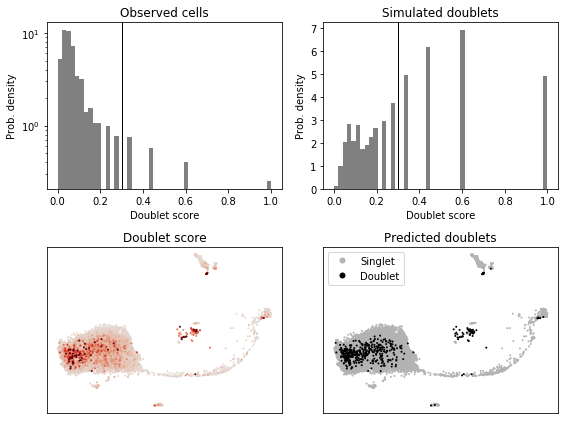

In [35]:
embedding = alldays_hvg.obsm['X_umap'][ix_12]
score_threshold = 0.3

fig, axs = scr.plot_scrublet_results(embedding, 
                                     scrublet_results_12['doublet_scores_observed_cells'], 
                                     scrublet_results_12['doublet_scores_simulated_doublets'], 
                                     score_threshold, 
                                     order_points = True, 
                                     marker_size = 4)

pl.show()

## E13.5

In [26]:
y_new=[s + '-1'for s in adata_13_raw.obs_names]
adata_13_raw.obs_names=y_new
adata_13_raw_filt=adata_13_raw[np.isin(adata_13_raw.obs_names,alldays_hvg.obs_names)].copy()

In [27]:
adata_13_raw_filt

AnnData object with n_obs × n_vars = 5158 × 27998 

In [28]:

# filtering/preprocessing parameters:
min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 50

# doublet detector parameters:
expected_doublet_rate = 0.08 
sim_doublet_ratio = 3
n_neighbors = 15

t0 = time.time()

scrublet_results_13 = scr.compute_doublet_scores(
    adata_13_raw_filt.X, 
    min_counts = min_counts, 
    min_cells = min_cells, 
    vscore_percentile = vscore_percentile, 
    n_prin_comps = n_pc,
    scaling_method = 'zscore',
    expected_doublet_rate = expected_doublet_rate,
    sim_doublet_ratio = sim_doublet_ratio,
    n_neighbors = n_neighbors, 
    use_approx_neighbors = True, 
    get_doublet_neighbor_parents = False
)


t1 = time.time()
print('Elapsed time: {:.1f} seconds'.format(t1 - t0))


Converting to scipy.sparse.csc_matrix
Simulating doublets
Total counts normalizing
Finding highly variable genes
Filtering genes from 27998 to 2347
Applying z-score normalization
Running PCA
Building kNN graph and calculating doublet scores
Elapsed time: 26.2 seconds


141/5158 = 2.7% of cells are predicted doublets.
57.5% of doublets are predicted to be detectable.
Predicted overall doublet rate = 4.8%


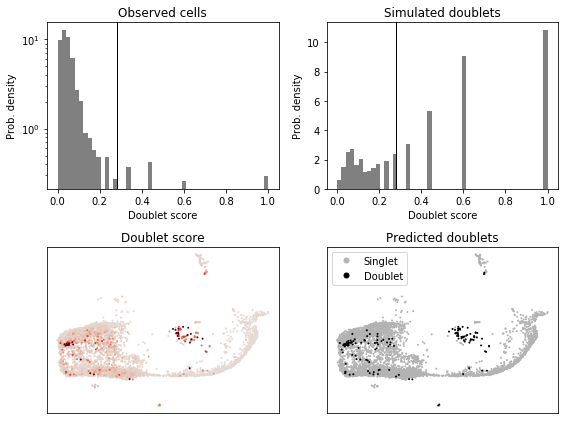

In [29]:
ix_13 = np.isin(alldays_hvg.obs['day'],'13.5')
embedding = alldays_hvg.obsm['X_umap'][ix_13]
score_threshold = 0.28

fig, axs = scr.plot_scrublet_results(embedding, 
                                     scrublet_results_13['doublet_scores_observed_cells'], 
                                     scrublet_results_13['doublet_scores_simulated_doublets'], 
                                     score_threshold, 
                                     order_points = True, 
                                     marker_size = 4)

pl.show()

## E14.5

In [37]:
y_new=[s + '-2'for s in adata_14_raw.obs_names]
adata_14_raw.obs_names=y_new
adata_14_raw_filt=adata_14_raw[np.isin(adata_14_raw.obs_names,alldays_hvg.obs_names)].copy()

In [38]:

# filtering/preprocessing parameters:
min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 50

# doublet detector parameters:
expected_doublet_rate = 0.08 
sim_doublet_ratio = 3
n_neighbors = 15

t0 = time.time()

scrublet_results_14 = scr.compute_doublet_scores(
    adata_14_raw_filt.X, 
    min_counts = min_counts, 
    min_cells = min_cells, 
    vscore_percentile = vscore_percentile, 
    n_prin_comps = n_pc,
    scaling_method = 'zscore',
    expected_doublet_rate = expected_doublet_rate,
    sim_doublet_ratio = sim_doublet_ratio,
    n_neighbors = n_neighbors, 
    use_approx_neighbors = True, 
    get_doublet_neighbor_parents = False
)


t1 = time.time()
print('Elapsed time: {:.1f} seconds'.format(t1 - t0))


Converting to scipy.sparse.csc_matrix
Simulating doublets
Total counts normalizing
Finding highly variable genes


/Users/sophie/miniconda3/lib/python3.5/site-packages/scrublet/helper_functions.py:125: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])


Filtering genes from 27998 to 2555
Applying z-score normalization
Running PCA
Building kNN graph and calculating doublet scores
Elapsed time: 72.6 seconds


540/10179 = 5.3% of cells are predicted doublets.
72.1% of doublets are predicted to be detectable.
Predicted overall doublet rate = 7.4%


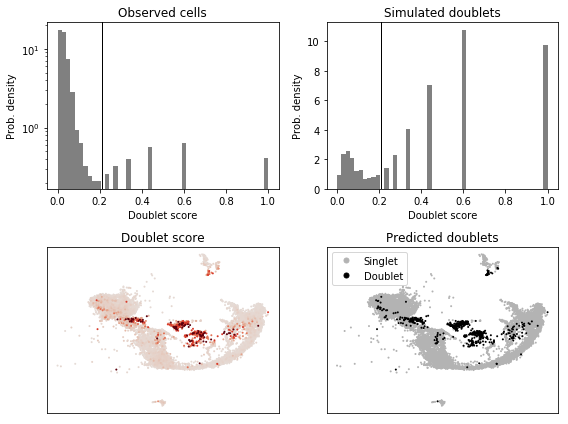

In [39]:
ix_14 = np.isin(alldays_hvg.obs['day'],'14.5')
embedding = alldays_hvg.obsm['X_umap'][ix_14]
score_threshold = 0.21

fig, axs = scr.plot_scrublet_results(embedding, 
                                     scrublet_results_14['doublet_scores_observed_cells'], 
                                     scrublet_results_14['doublet_scores_simulated_doublets'], 
                                     score_threshold, 
                                     order_points = True, 
                                     marker_size = 4)

pl.show()

## E15.5

In [40]:
y_new=[s + '-3'for s in adata_15_raw.obs_names]
adata_15_raw.obs_names=y_new
adata_15_raw_filt=adata_15_raw[np.isin(adata_15_raw.obs_names,alldays_hvg.obs_names)].copy()
# filtering/preprocessing parameters:

In [41]:

min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 50

# doublet detector parameters:
expected_doublet_rate = 0.08 
sim_doublet_ratio = 3
n_neighbors = 15

t0 = time.time()

scrublet_results_15 = scr.compute_doublet_scores(
    adata_15_raw_filt.X, 
    min_counts = min_counts, 
    min_cells = min_cells, 
    vscore_percentile = vscore_percentile, 
    n_prin_comps = n_pc,
    scaling_method = 'zscore',
    expected_doublet_rate = expected_doublet_rate,
    sim_doublet_ratio = sim_doublet_ratio,
    n_neighbors = n_neighbors, 
    use_approx_neighbors = True, 
    get_doublet_neighbor_parents = False
)


t1 = time.time()
print('Elapsed time: {:.1f} seconds'.format(t1 - t0))


Converting to scipy.sparse.csc_matrix
Simulating doublets
Total counts normalizing
Finding highly variable genes


/Users/sophie/miniconda3/lib/python3.5/site-packages/scrublet/helper_functions.py:125: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])


Filtering genes from 27998 to 2594
Applying z-score normalization
Running PCA
Building kNN graph and calculating doublet scores
Elapsed time: 66.9 seconds


810/11422 = 7.1% of cells are predicted doublets.
66.7% of doublets are predicted to be detectable.
Predicted overall doublet rate = 10.6%


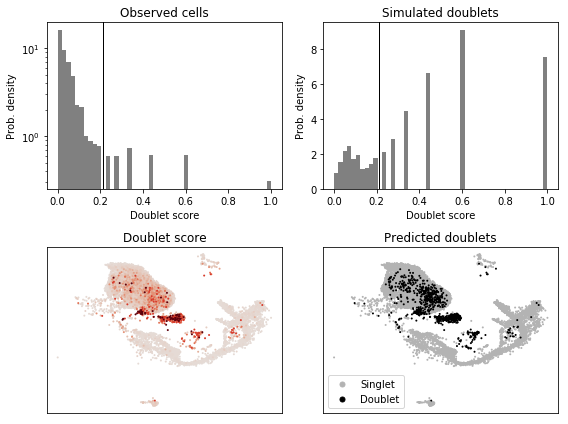

In [42]:
ix_15 = np.isin(alldays_hvg.obs['day'],'15.5')
embedding = alldays_hvg.obsm['X_umap'][ix_15]
score_threshold = 0.21

fig, axs = scr.plot_scrublet_results(embedding, 
                                     scrublet_results_15['doublet_scores_observed_cells'], 
                                     scrublet_results_15['doublet_scores_simulated_doublets'], 
                                     score_threshold, 
                                     order_points = True, 
                                     marker_size = 4)

pl.show()

In [43]:
scores=np.hstack([scrublet_results_12['doublet_scores_observed_cells'],
               scrublet_results_13['doublet_scores_observed_cells'],
               scrublet_results_14['doublet_scores_observed_cells'],
               scrublet_results_15['doublet_scores_observed_cells']])

37216

In [44]:
alldays_hvg.obs['doublet_scores']=scores

# Clustering

## Ngn3 positive cells

In [7]:
alldays_hvg.obs['Ngn3+'] = pd.Categorical(list(map(str,list(alldays[:,'Neurog3'].X > 0))))

## overall clustering

Clustering and refinements were done iteratively at different resolutions. Clusters were annotated based on the expression of marker genes.

In [651]:
# Perform clustering - using highly variable genes
sc.tl.louvain(alldays_hvg, key_added='louvain_11')
sc.tl.louvain(alldays_hvg, resolution=0.5, key_added='louvain_12')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:17.04) --> found 23 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:12.88) --> found 13 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical)


In [652]:
sc.tl.louvain(alldays_hvg, key_added='louvain_11')
sc.tl.louvain(alldays_hvg, resolution=0.5, key_added='louvain_12')
sc.tl.louvain(alldays_hvg, restrict_to=('louvain_12', ['8']), resolution=0.2, key_added='louvain_13') #-> probably not needed
sc.tl.louvain(alldays_hvg, restrict_to=('louvain_13', ['1']), resolution=0.2, key_added='louvain_14')
sc.tl.louvain(alldays_hvg, restrict_to=('louvain_14', ['1,3']), resolution=0.1, key_added='louvain_15')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:17.26) --> found 23 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:10.66) --> found 13 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.19) --> found 4 clusters and added
    'l05_zoom_8', the cluster labels (adata.obs, categorical)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.76) --> found 4 clusters and added
    'l05_zoom_8_1', the cluster labels (adata.obs, categorical)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.06) --> found 2 clusters and added
    'l05_zoom_8_1_1,3', the cluster labels (adata.obs, categorical)


In [653]:
sc.tl.louvain(alldays_hvg,restrict_to=('louvain_15',['1,3,0']),resolution=0.5,key_added='louvain_16')
sc.tl.louvain(alldays_hvg,restrict_to=('louvain_16',['1,3,0,2']),resolution=0.5,key_added='louvain_17')
sc.tl.louvain(alldays_hvg,restrict_to=('louvain_17',['1,0']),resolution=0.5,key_added='louvain_18')
sc.tl.louvain(alldays_hvg,restrict_to=('louvain_18',['1,0,0']),resolution=0.5,key_added='louvain_19')
sc.tl.louvain(alldays_hvg,resolution=0.2,key_added='louvain_new',restrict_to=('louvain_19',['7'])) 
sc.tl.louvain(alldays_hvg,resolution=0.3,key_added='louvain_new',restrict_to=('louvain_new',['7,0']))
sc.tl.louvain(alldays_hvg,resolution=0.3,key_added='louvain_new',restrict_to=('louvain_new',['2'])) 
sc.tl.louvain(alldays_hvg,resolution=0.5,key_added='louvain_new',restrict_to=('louvain_new',['3']))  
sc.tl.louvain(alldays_hvg,resolution=0.3,key_added='louvain_new',restrict_to=('louvain_new',['3,1']))
sc.tl.louvain(alldays_hvg,resolution=0.2,restrict_to=('louvain_new',['8,1']),key_added='louvain_new2')
sc.tl.louvain(alldays_hvg,resolution=0.15,restrict_to=('louvain_new',['1,1']),key_added='louvain_new3')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.05) --> found 5 clusters and added
    'louvain_16', the cluster labels (adata.obs, categorical)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.01) --> found 2 clusters and added
    'louvain_17', the cluster labels (adata.obs, categorical)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.18) --> found 6 clusters and added
    'louvain_18', the cluster labels (adata.obs, categorical)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.05) --> found 4 clusters and added
    'louvain_19', the cluster labels (adata.obs, categorical)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.47) --> found 3 clusters and added
    'louvain_new', the cluster labels (adata.obs, categorical)
running Louvain clustering
  

## cluster annotations

### Figure 3

In [8]:
ref_cluster=pd.Categorical(alldays_hvg.obs['louvain_19'],
                           categories=['0', '1,0,0,0', '1,0,0,1', '1,0,0,2', '1,0,0,3', '1,0,1', '1,0,2',
       '1,0,3', '1,0,4', '1,0,5', '1,1', '1,2', '1,3,0,0', '1,3,0,1',
       '1,3,0,2,0', '1,3,0,2,1', '1,3,0,3', '1,3,0,4', '1,3,1', '2,0', '2,1',
       '2,2', '2,3', '3,0', '3,1,0', '3,1,1', '3,1,2', '3,1,3', '3,2', '3,3',
       '3,4', '3,5', '3,6', '3,7', '4', '5', '6', '7,0,0', '7,0,1', '7,0,2','2', '3','7',
       '7,0,3', '7,1', '7,2', '8,0', '8,1', '8,2','8,3','9', '10', '11', '12','Multipotent','Tip','Prlf. Tip',
                                                                 'Prlf. Acinar','Mat. Acinar','Trunk','Prlf. Trunk',
                                                                 'Ductal','Prlf. Ductal','Ngn3 low EP','Ngn3 high EP',
                                                                 'Fev+','Endocrine','Other/Doublet',
                                      'Fev_unknown','Fev_Pyy_Gast','Fev_Alpha','Fev_Alpha_early','Fev_Beta','Fev_Beta_early',
                                      'Alpha', 'Beta','Delta','Epsilon'])


ref_cluster2=pd.Categorical(alldays_hvg.obs['louvain_new'])

ix=np.isin(ref_cluster,['9','10','11','12'])
ref_cluster[ix]='Other/Doublet'

ix=np.isin(ref_cluster,['0'])
#ix=np.isin(ref_cluster,['Ductal_1'])
ref_cluster[ix]='Mat. Acinar'

ix=np.isin(ref_cluster,['6'])
#ix=np.isin(ref_cluster,['Ductal_1'])
ref_cluster[ix]='Prlf. Acinar'


ix=np.isin(ref_cluster,['5'])
#ix=np.isin(ref_cluster,['Ductal_1'])
ref_cluster[ix]='Ductal'

ix=np.isin(ref_cluster,['3'])
ref_cluster[ix]='Ductal'

 
ix=np.isin(ref_cluster,['7'])
ref_cluster[ix]='Prlf. Trunk'

ix=np.isin(ref_cluster2,['3,6'])
ref_cluster[ix]='Prlf. Trunk'


ix=np.isin(ref_cluster2,['3,5'])
ref_cluster[ix]='Trunk'


ix=np.isin(ref_cluster2,['7,2'])
ref_cluster[ix]='Trunk'



ix=np.isin(ref_cluster2,['7,1','7,0,1'])
ref_cluster[ix]='Multipotent'


ix=np.isin(ref_cluster,['4'])
ref_cluster[ix]='Tip'



ix=np.isin(ref_cluster2,['2,1','2,0'])
ref_cluster[ix]='Prlf. Tip'




ix=np.isin(ref_cluster2,['3,1,0','3,1,1','3,1,3','3,3','3,4','2,3','2,2'])
ref_cluster[ix]='Prlf. Ductal'

ix=np.isin(ref_cluster2,['3,1,2'])
ref_cluster[ix]='Tip'





ix=np.isin(ref_cluster,['1,3,0,2,0','1,3,0,2,2','1,0,5'])
#ix=np.isin(ref_cluster,['Epsilon,2,0','Epsilon,2,2','FevHi\n(Ngn3Lo),5'])
ref_cluster[ix]='Fev_unknown'

ix=np.isin(ref_cluster,['1,3,0,0'])
ref_cluster[ix]='Fev_Pyy_Gast'

ix=np.isin(ref_cluster,['1,0,0,2'])
ref_cluster[ix]='Fev_Alpha'

ix=np.isin(ref_cluster,['1,0,4'])
ref_cluster[ix]='Fev_Alpha_early'


ix=np.isin(ref_cluster,['1,0,2','1,0,0,0','1,0,0,1'])
ref_cluster[ix]='Fev_Beta'


ix=np.isin(ref_cluster,['1,0,1','1,0,0,3','1,0,3'])
ref_cluster[ix]='Fev_Beta_early'

ix=np.isin(ref_cluster,['Fev_unknown','Fev_Pyy_Gast','Fev_Alpha','Fev_Alpha_early','Fev_Beta','Fev_Beta_early','1,3,0,2,1','1,3,0,3'])
ref_cluster[ix]='Fev+'


ix=np.isin(ref_cluster,['1,1'])
ref_cluster[ix]='Alpha'

ix=np.isin(ref_cluster,['1,2'])
ref_cluster[ix]='Beta'

ix=np.isin(ref_cluster,['1,3,0,1',
        '1,3,0,4'])
ref_cluster[ix]='Epsilon'


ix=np.isin(ref_cluster,['1,3,1'])
ref_cluster[ix]='Delta'


ix=np.isin(ref_cluster,['Alpha', 'Beta','Delta','Epsilon'])
ref_cluster[ix]='Endocrine'



ix=np.isin(ref_cluster,['Multipotent','Tip','Prlf. Tip','Trunk',
                        'Prlf. Trunk','Ductal','Prlf. Ductal']) & (alldays_hvg.obs['Ngn3+'] == 'True')
ref_cluster[ix]='Ngn3 low EP'

ix=np.isin(ref_cluster,['8,0', '8,1', '8,2', '8,3'])
ref_cluster[ix]='Ngn3 high EP'


alldays_hvg.obs['clusters_fig3_final']=pd.Categorical(ref_cluster,
                                                     categories=['Multipotent','Tip','Prlf. Tip',
                                                                 'Prlf. Acinar','Mat. Acinar','Trunk','Prlf. Trunk',
                                                                 'Ductal','Prlf. Ductal','Ngn3 low EP','Ngn3 high EP',
                                                                 'Fev+','Endocrine','Other/Doublet'])#'Prlf. EP',

In [9]:
ref_cluster=pd.Categorical(alldays_hvg.obs['louvain_19'],
                           categories=['0', '1,0,0,0', '1,0,0,1', '1,0,0,2', '1,0,0,3', '1,0,1', '1,0,2',
       '1,0,3', '1,0,4', '1,0,5', '1,1', '1,2', '1,3,0,0', '1,3,0,1',
       '1,3,0,2,0', '1,3,0,2,1', '1,3,0,3', '1,3,0,4', '1,3,1', '2,0', '2,1',
       '2,2', '2,3', '3,0', '3,1,0', '3,1,1', '3,1,2', '3,1,3', '3,2', '3,3',
       '3,4', '3,5', '3,6', '3,7', '4', '5', '6', '7,0,0', '7,0,1', '7,0,2','2', '3','7',
       '7,0,3', '7,1', '7,2', '8,0', '8,1', '8,2','8,3', '9', '10', '11', '12','Multipotent','Tip','Prlf. Tip',
                                                                 'Prlf. Acinar','Mat. Acinar','Trunk','Prlf. Trunk',
                                                                 'Ductal','Prlf. Ductal','Ngn3 low EP','Ngn3 high EP',
                                                                 'Fev+','Endocrine','Other/Doublet',
                                      'Fev_unknown','Fev_Pyy_Gast','Fev_Alpha','Fev_Alpha_early','Fev_Beta','Fev_Beta_early',
                                      'Alpha', 'Beta','Delta','Epsilon'])


ref_cluster2=pd.Categorical(alldays_hvg.obs['louvain_new'])

ix=np.isin(ref_cluster,['9','10','11','12'])
ref_cluster[ix]='Other/Doublet'

ix=np.isin(ref_cluster,['0'])
ref_cluster[ix]='Mat. Acinar'

ix=np.isin(ref_cluster,['6'])
ref_cluster[ix]='Prlf. Acinar'


ix=np.isin(ref_cluster,['5'])
ref_cluster[ix]='Ductal'

ix=np.isin(ref_cluster,['3'])
ref_cluster[ix]='Ductal'

 
ix=np.isin(ref_cluster,['7'])
ref_cluster[ix]='Prlf. Trunk'

ix=np.isin(ref_cluster2,['3,6'])
ref_cluster[ix]='Prlf. Trunk'


ix=np.isin(ref_cluster2,['3,5'])
ref_cluster[ix]='Trunk'


ix=np.isin(ref_cluster2,['7,2'])
ref_cluster[ix]='Trunk'



ix=np.isin(ref_cluster2,['7,1','7,0,1'])
ref_cluster[ix]='Multipotent'


ix=np.isin(ref_cluster,['4'])
ref_cluster[ix]='Tip'



ix=np.isin(ref_cluster2,['2,1','2,0'])
ref_cluster[ix]='Prlf. Tip'




ix=np.isin(ref_cluster2,['3,1,0','3,1,1','3,1,3','3,3','3,4','2,3','2,2'])
ref_cluster[ix]='Prlf. Ductal'

ix=np.isin(ref_cluster2,['3,1,2'])
ref_cluster[ix]='Tip'





ix=np.isin(ref_cluster,['1,3,0,2,0','1,3,0,2,2','1,0,5'])
ref_cluster[ix]='Fev_unknown'

ix=np.isin(ref_cluster,['1,3,0,0'])
ref_cluster[ix]='Fev_Pyy_Gast'

ix=np.isin(ref_cluster,['1,0,0,2'])
ref_cluster[ix]='Fev_Alpha'

ix=np.isin(ref_cluster,['1,0,4'])
ref_cluster[ix]='Fev_Alpha_early'


ix=np.isin(ref_cluster,['1,0,2','1,0,0,0','1,0,0,1'])
ref_cluster[ix]='Fev_Beta'


ix=np.isin(ref_cluster,['1,0,1','1,0,0,3','1,0,3'])
ref_cluster[ix]='Fev_Beta_early'

ix=np.isin(ref_cluster,['Fev_unknown','Fev_Pyy_Gast','Fev_Alpha','Fev_Alpha_early','Fev_Beta','Fev_Beta_early','1,3,0,2,1','1,3,0,3'])
ref_cluster[ix]='Fev+'


ix=np.isin(ref_cluster,['1,1'])
ref_cluster[ix]='Alpha'

ix=np.isin(ref_cluster,['1,2'])
ref_cluster[ix]='Beta'

ix=np.isin(ref_cluster,['1,3,0,1',
        '1,3,0,4'])
ref_cluster[ix]='Epsilon'


ix=np.isin(ref_cluster,['1,3,1'])
ref_cluster[ix]='Delta'


ix=np.isin(ref_cluster,['Alpha', 'Beta','Delta','Epsilon'])
ref_cluster[ix]='Endocrine'


ix=np.isin(ref_cluster,['8,0', '8,1', '8,2', '8,3'])
ref_cluster[ix]='Ngn3 high EP'


alldays_hvg.obs['clusters_fig3_final_noep']=pd.Categorical(ref_cluster,
                                                     categories=['Multipotent','Tip','Prlf. Tip',
                                                                 'Prlf. Acinar','Mat. Acinar','Trunk','Prlf. Trunk',
                                                                 'Ductal','Prlf. Ductal','Ngn3 high EP',
                                                                 'Fev+','Endocrine','Other/Doublet'])#'Prlf. EP',

In [10]:
alldays_hvg.uns['clusters_fig3_final_noep_colors']=['#67000D',#mulitpotent A
'#5D706D',#tip
'#004D43',#mat. acinar,                                              
'#2265A3',#trunk
'#031A5C',#ductal          
'#fdbf6f',#ep
'#ff7f00',#Fev+
'#e31a1c',#endocrine
'#f0f0f0']#unassigned]

In [11]:
alldays_hvg.uns['clusters_fig3_final_colors']=['#67000D',#mulitpotent A
'#5D706D',#tip
'#67B237',#prlf. tip                                              
'#008941',#prolif. acinar
'#004D43',#mat. acinar,                                              
'#ae017e',#trunk
'#A0D4FF',#prlf. trunk                                             
'#031A5C',#ductal                                               
'#2171b5',# Prlf. ductal
'#fa9fb5',#early ep
'#fdbf6f',#ep
'#ff7f00',#Fev+
'#e31a1c',#endocrine
'#f0f0f0']#unassigned]

### Figure 2

In [12]:
ref_clust=pd.Categorical(alldays_hvg.obs['clusters_fig3_final'],categories=['Multipotent','Tip','Prlf. Tip',
                                                                 'Prlf. Acinar','Mat. Acinar','Trunk','Prlf. Trunk',
                                                                 'Ductal','Prlf. Ductal','Ngn3 low EP','Ngn3 high EP',
                                                                 'Fev+','Endocrine','Other/Doublet','Acinar','EP'])#'Prlf. EP',

ix=np.isin(ref_clust,['Tip','Prlf. Tip'])
ref_clust[ix]='Tip'

ix=np.isin(ref_clust,['Trunk','Prlf. Trunk'])
ref_clust[ix]='Trunk'


ix=np.isin(ref_clust,['Prlf. Acinar','Mat. Acinar'])
ref_clust[ix]='Acinar'

ix=np.isin(ref_clust,['Ductal','Prlf. Ductal'])
ref_clust[ix]='Ductal'

ix=np.isin(ref_clust,['Ngn3 low EP','Ngn3 high EP'])
ref_clust[ix]='EP'

alldays_hvg.obs['clusters_fig2_final']=pd.Categorical(ref_clust,
                                                     categories=['Multipotent','Tip',
                                                                 'Acinar','Trunk',
                                                                 'Ductal','EP',
                                                                 'Fev+','Endocrine','Other/Doublet'])#'Prlf. EP',


In [13]:
alldays_hvg.uns['clusters_fig2_final_colors']=['#67000d',
 '#67B237','#004D43',
 '#A0D4FF',
 '#031A5C',
 '#fdbf6f',
'#ff7f00',
'#e31a1c',
'#d9d9d9']

### Figure 4

In [14]:
ref_cluster=pd.Categorical(alldays_hvg.obs['clusters_fig3_final'],
                           categories=['Multipotent', 'Tip', 'Prlf. Tip', 'Prlf. Acinar', 'Mat. Acinar',
       'Trunk', 'Prlf. Trunk', 'Ductal', 'Prlf. Ductal', 'Ngn3 low EP',
       'Ngn3 high EP', 'Fev+', 'Endocrine','Excluded','Ductal Bipotent','Other/Doublet'])
                           
ix=np.isin(ref_cluster,['Prlf. Ductal','Ductal'])
ref_cluster[ix]='Ductal Bipotent'

ix=np.isin(ref_cluster,['Multipotent', 'Tip', 'Prlf. Tip', 'Prlf. Acinar', 'Mat. Acinar',
       'Trunk', 'Prlf. Trunk','Endocrine','Other/Doublet'])
ref_cluster[ix]='Excluded'

alldays_hvg.obs['clusters_fig4_final']=pd.Categorical(ref_cluster,
                                              categories=['Ductal Bipotent','Ngn3 low EP','Ngn3 high EP', 'Fev+','Excluded'])

In [15]:
alldays_hvg.uns['clusters_fig4_final_colors']=['#390032','#fa9fb5', '#fdbf6f', '#ff7f00','#d9d9d9']

### Figure 6 and 7

In [16]:
ref_cluster=pd.Categorical(alldays_hvg.obs['clusters_fig2_final'],
                           categories=['Multipotent', 'Tip','Acinar','EP',
       'Trunk', 'Ductal','Ngn3 low EP',
       'Ngn3 High early','Ngn3 High late',
                    'Fev+ Beta','Beta','Fev+ Alpha','Alpha',
                     'Fev+ Pyy','Fev+ Delta','Fev+ Epsilon','Delta','Epsilon','Fev+', 'Endocrine', 'Other/Doublet'])
                                    
ref_cluster3=alldays_hvg.obs['clusters_fig3_final']


ix=np.isin(ref_cluster3,['Ngn3 low EP'])
ref_cluster[ix]='Ngn3 low EP'


ref_cluster2=alldays_hvg.obs['louvain_19']

ix=np.isin(ref_cluster2,['1,3,1'])
ref_cluster[ix]='Delta'
ix=np.isin(ref_cluster2,['1,1'])
ref_cluster[ix]='Alpha'
ix=np.isin(ref_cluster2,['1,2'])
ref_cluster[ix]='Beta'
    

ix=np.isin(ref_cluster2,['1,3,0,1',
       '1,3,0,4'])
ref_cluster[ix]='Epsilon'


ix=np.isin(ref_cluster2,['1,3,0,2,0','1,3,0,2,2','1,3,0,2,1'])
ref_cluster[ix]='Fev+ Epsilon'

ix=np.isin(ref_cluster2,['1,0,5'])
ref_cluster[ix]='Other/Doublet'



ix=np.isin(ref_cluster2,['1,3,0,0'])
ref_cluster[ix]='Fev+ Pyy'

ix=np.isin(ref_cluster2,['1,0,0,2'])
ref_cluster[ix]='Fev+ Alpha'

ix=np.isin(ref_cluster2,['1,0,4'])
ref_cluster[ix]='Fev+ Alpha'


ix=np.isin(ref_cluster2,['1,0,2','1,0,0,0','1,0,0,1'])
ref_cluster[ix]='Fev+ Beta'


ix=np.isin(ref_cluster2,['1,0,1','1,0,0,3','1,0,3'])
ref_cluster[ix]='Fev+ Beta'


ix=np.isin(ref_cluster2,['1,3,0,3'])
ref_cluster[ix]='Fev+ Delta'


ix=np.isin(ref_cluster2,['8,0','8,3'])
ref_cluster[ix]='Ngn3 High late'

ix=np.isin(ref_cluster2,['8,2'])
ref_cluster[ix]='Ngn3 High early'

ref_cluster3=alldays_hvg.obs['louvain_new2']
ix=np.isin(ref_cluster3,['8,1,0','8,1,2'])
ref_cluster[ix]='Ngn3 High late'

ix=np.isin(ref_cluster3,['8,1,1'])
ref_cluster[ix]='Ngn3 High early'

alldays_hvg.obs['clusters_fig6_fine_final']=pd.Categorical(ref_cluster,categories=['Multipotent', 'Tip',
                                                                          'Acinar', 
       'Trunk', 'Ductal','Ngn3 low EP',
       'Ngn3 High early','Ngn3 High late',
                    'Fev+ Beta','Beta','Fev+ Alpha','Alpha',
                     'Fev+ Pyy','Fev+ Delta','Fev+ Epsilon','Delta','Epsilon','Other/Doublet'])


In [17]:
ref_cluster=pd.Categorical(alldays_hvg.obs['clusters_fig6_fine_final'],
                           categories=['Multipotent', 'Tip',
                                                                          'Acinar',
       'Trunk', 'Ductal','Ngn3 low EP',
       'Ngn3 High early','Ngn3 High late',
                    'Fev+ Beta','Beta','Fev+ Alpha','primary Alpha','secondary Alpha',
                     'Fev+ Pyy','Fev+ Delta','Fev+ Epsilon','Delta','Epsilon','Other/Doublet','Alpha'])


ref_cluster3=alldays_hvg.obs['louvain_new3']
ix=np.isin(ref_cluster3,['1,1,1'])
ref_cluster[ix]='primary Alpha'

ix=np.isin(ref_cluster3,['1,1,0'])
ref_cluster[ix]='secondary Alpha'


alldays_hvg.obs['clusters_fig6_alpha_final']=pd.Categorical(ref_cluster,categories=['Multipotent', 'Tip',
                                                                          'Prlf. Acinar', 'Mat. Acinar',
       'Trunk', 'Ductal','Ngn3 low EP',
       'Ngn3 High early','Ngn3 High late',
                    'Fev+ Beta','Beta','Fev+ Alpha','primary Alpha','secondary Alpha',
                     'Fev+ Pyy','Fev+ Delta','Fev+ Epsilon','Delta','Epsilon','Other/Doublet'])


In [18]:
ref_cluster=pd.Categorical(alldays_hvg.obs['clusters_fig3_final'],
                           categories=['Multipotent', 'Tip', 'Prlf. Tip','Prlf. Acinar', 'Mat. Acinar',
       'Trunk', 'Prlf. Trunk', 'Ductal', 'Prlf. Ductal', 'Ngn3 low EP','Ngn3 high EP','Fev+','Endocrine',
       'Beta','Alpha','Delta','Epsilon','Other/Doublet'])
                                    
ref_cluster2=alldays_hvg.obs['clusters_fig6_fine_final']

ix=np.isin(ref_cluster2,['Beta'])
ref_cluster[ix]='Beta'

ix=np.isin(ref_cluster2,['Alpha'])
ref_cluster[ix]='Alpha'

ix=np.isin(ref_cluster2,['Delta'])
ref_cluster[ix]='Delta'

ix=np.isin(ref_cluster2,['Epsilon'])
ref_cluster[ix]='Epsilon'

alldays_hvg.obs['clusters_fig6_broad_final']=pd.Categorical(ref_cluster,categories=['Multipotent', 'Tip', 'Prlf. Tip','Prlf. Acinar', 'Mat. Acinar',
       'Trunk', 'Prlf. Trunk', 'Ductal', 'Prlf. Ductal', 'Ngn3 low EP','Ngn3 high EP','Fev+',
       'Beta','Alpha','Delta','Epsilon','Other/Doublet'])

In [19]:
alldays_hvg.uns['clusters_fig6_alpha_final_colors']=['#f0f0f0','#f0f0f0','#f0f0f0','#f0f0f0','#f0f0f0','#f0f0f0','#f0f0f0','#f0f0f0','#f0f0f0','#f0f0f0','#f0f0f0','#f0f0f0',
 '#DD58E8',
 '#8dd593','#f0f0f0','#f0f0f0','#f0f0f0','#f0f0f0','#f0f0f0','#f0f0f0',]

alldays_hvg.uns['clusters_fig6_fine_final_colors']=[
       '#f0f0f0','#f0f0f0','#f0f0f0','#f0f0f0','#f0f0f0','#f0f0f0',
       '#A0D4FF','#B1ECCB','#9CD172','#779F57','#A0D4FF','#1F75C3',    
       '#CE6566','#DD58E8','#BEA3CE','#6a3d9a','#7C6A86','#f0f0f0']

In [20]:
alldays_hvg.uns['clusters_fig6_broad_final_colors']=[
    '#67000D','#5D706D','#67B237','#008941','#004D43','#2265A3',
    '#aec7e8','#031A5C','#7d87b9','#fa9fb5','#fdbf6f','#ff7f00',
    '#b2df8a','#1f78b4','#6a3d9a','#cab2d6','#f0f0f0']

## nice colorbars for figures

In [ ]:
## vertical
rcParams['figure.figsize'] = (2,6)
import matplotlib as mpl
fig, ax = pl.subplots()
col_map = pl.get_cmap('viridis')
mpl.colorbar.ColorbarBase(ax, cmap=col_map, orientation = 'vertical')
ax.set_yticklabels(ax.get_yticklabels(),fontdict={'size':16})
pl.tight_layout()
pl.savefig('./pseudotime_colorbar.pdf',dpi=300,format='pdf')
pl.show()
pl.rcParams.update(pl.rcParamsDefault)

## horizontal
rcParams['figure.figsize'] = (6,2)
import matplotlib as mpl
fig, ax = pl.subplots()
col_map = pl.get_cmap('magma')
mpl.colorbar.ColorbarBase(ax, cmap=col_map, orientation = 'horizontal')
ax.set_yticklabels(ax.get_yticklabels(),fontdict={'size':16})
pl.tight_layout()
pl.savefig('./colorbar_pseudotime.pdf',dpi=300,format='pdf')
pl.show()
pl.rcParams.update(pl.rcParamsDefault)

# Removal of non-epithelial cell populations and doublets

we remove non-epithelial clusters as well as two doublet-clusters (see separate notebook for doublet detection) for further analyses.

In [28]:
ix=np.isin(alldays_hvg.obs['clusters_fig2_final'],['Other/Doublet'])
adata_hvg=alldays_hvg[np.invert(ix)].copy()
adata_all=alldays[np.invert(ix)].copy()

ix=np.isin(adata_hvg.obs['clusters_fig6_fine_final'],['Other/Doublet'])
adata_hvg=adata_hvg[np.invert(ix)].copy()
adata_all=adata_all[np.invert(ix)].copy()

In [29]:
ix=np.isin(alldays_hvg.obs_names,adata_hvg.obs_names)

In [45]:
adata_hvg.uns['clusters_fig2_final_colors']=alldays_hvg.uns['clusters_fig2_final_colors']


adata_hvg.uns['clusters_fig3_final_colors']=alldays_hvg.uns['clusters_fig3_final_colors']
adata_hvg.uns['clusters_fig3_final_noep_colors']=alldays_hvg.uns['clusters_fig3_final_noep_colors']

adata_hvg.uns['clusters_fig4_final_colors']=alldays_hvg.uns['clusters_fig4_final_colors']
adata_hvg.uns['clusters_fig6_broad_final_colors']=alldays_hvg.uns['clusters_fig6_broad_final_colors']
adata_hvg.uns['clusters_fig6_fine_final_colors']=alldays_hvg.uns['clusters_fig6_fine_final_colors']
adata_hvg.uns['clusters_fig6_alpha_final_colors']=alldays_hvg.uns['clusters_fig6_alpha_final_colors']

In [690]:
# update the colorpalette
adata_hvg.uns['clusters_fig3_final_colors']=['#67000D',#mulitpotent A
'#5D706D',#tip
'#67B237',#prlf. tip                                              
'#008941',#prolif. acinar
'#004D43',#mat. acinar,
'#ae017e',#trunk
'#A0D4FF',#prlf. trunk                                              
'#031A5C',#ductal                                               
'#2171b5',# Prlf. ductal
'#fa9fb5',#early ep
'#fdbf6f',#ep
'#ff7f00',#Fev+
'#e31a1c']#unassigned

In [47]:
adata_all.obs['clusters_fig3_final']=adata_hvg.obs['clusters_fig3_final']
adata_all.obs['clusters_fig3_final_noep']=adata_hvg.obs['clusters_fig3_final_noep']
adata_all.obs['clusters_fig4_final']=adata_hvg.obs['clusters_fig4_final']
adata_all.obs['clusters_fig2_final']=adata_hvg.obs['clusters_fig2_final']
adata_all.obs['clusters_fig6_broad_final']=adata_hvg.obs['clusters_fig6_broad_final']
adata_all.obs['clusters_fig6_fine_final']=adata_hvg.obs['clusters_fig6_fine_final']
adata_all.obs['clusters_fig6_alpha_final']=adata_hvg.obs['clusters_fig6_alpha_final']

In [50]:
adata_all.uns['clusters_fig2_final_colors']=adata_hvg.uns['clusters_fig2_final_colors']
adata_all.uns['Ngn3+_colors']=adata_hvg.uns['Ngn3+_colors']
adata_all.uns['clusters_fig3_final_colors']=adata_hvg.uns['clusters_fig3_final_colors']
adata_all.uns['clusters_fig3_final_noep_colors']=adata_hvg.uns['clusters_fig3_final_noep_colors']
adata_all.uns['clusters_fig4_final_colors']=adata_hvg.uns['clusters_fig4_final_colors']
adata_all.uns['clusters_fig6_broad_final_colors']=adata_hvg.uns['clusters_fig6_broad_final_colors']
adata_all.uns['clusters_fig6_fine_final_colors']=adata_hvg.uns['clusters_fig6_fine_final_colors']
adata_all.uns['clusters_fig6_alpha_final_colors']=adata_hvg.uns['clusters_fig6_alpha_final_colors']

# UMAP recalculation

We initialize the UMAP embedding with manually set paga positions.  
_Note: recalculation of the knn did not change or affect downstream results_

running partition-based graph abstraction (PAGA)
    finished (0:00:01.74) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
--> added 'pos', the PAGA positions (adata.uns['paga'])


/Users/sophie/miniconda3/envs/scanpy_ngn3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


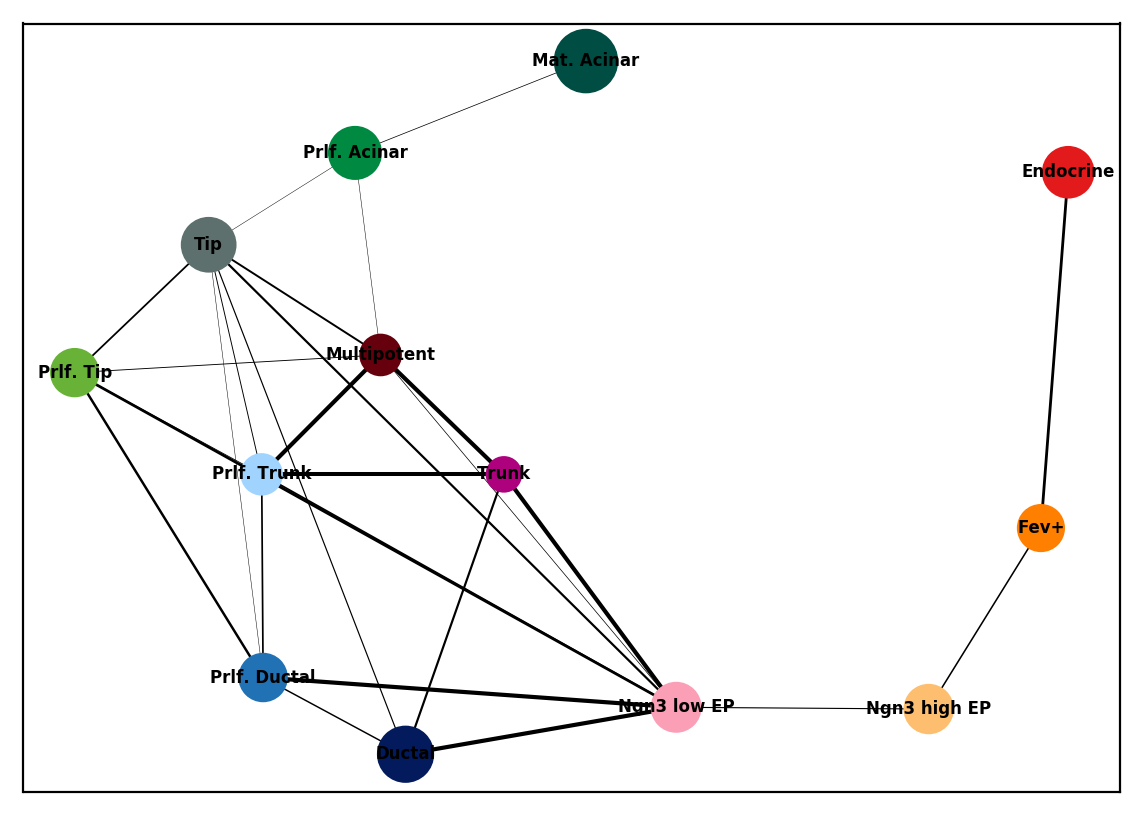

In [271]:
sc.tl.paga(adata_hvg,groups='clusters_fig3_final')
pos=np.array([[-3.276080093 , -1.2],#mpc
       [-5.1822512769, 0],#tip
       [-6.6674343885, -1.39223995  ],#prlf tip
       [-3.5600819481,  1],#prlf acinar
       [-1,  2],#mat acinar
       [-1.9095328425, -2.5],#trunk
       [-4.5944196209, -2.5],#prlf trunk
       [-3, -5.5473209737],#duct
       [-4.5787940696, -4.7118794041],#prlf.duct
       [0, -5.0359884718],#early ep
       [ 2.7994142546, -5.0550800284],#ep
       [4.0438095194, -3.0846208514],#pre-endo
       [4.3462040595,  0.7894487691]])#,#endo
sc.pl.paga(adata_hvg,edge_width_scale=0.2,threshold=0.11,pos=pos,fontsize=6,node_size_scale=2)

In [89]:
sc.tl.umap(adata_hvg,init_pos='paga')

computing UMAP
    finished (0:00:28.17) --> added
    'X_umap', UMAP coordinates (adata.obsm)


In [ ]:
adata_all.obsm['X_umap']=adata_hvg.obsm['X_umap']

# Read and write data

In [701]:
alldays_hvg.write('/adata_hvg_nonfiltered.h5ad')

In [ ]:
alldays.write('/adata_nonfiltered.h5ad')

In [649]:
#alldays_hvg=sc.read('./adata_hvg_nonfiltered.h5ad')

In [ ]:
#alldays=sc.read('./adata_nonfiltered.h5ad')

In [ ]:
sc.write('./adata.h5ad',adata_all)
sc.write('./adata_hvg.h5ad',adata_hvg)